In [1]:
! rm -r spectrogram_cache
! rm -r Data/ismir_wav

rm: spectrogram_cache: No such file or directory
rm: Data/ismir_wav: No such file or directory


In [2]:
from data_processing.data_loader import load_music_tags_dataset, load_audio_data, process_audio_in_parallel
from data_processing.labels_processing import preprocess_labels
from data_processing.data_loader import process_audio_to_melspectrogram
from data_processing.data_loader import convert_spectrogram_image_to_mel
from data_processing.data_loader import process_images_in_parallel
from data_processing.mp3_processing import process_ismir_dataset
from utils import GENRE_MAP
from utils import visualize_attention
from utils import multilabel_undersample
from utils import run_experiment
from utils import load_model
from utils import bootstrap_f1
import numpy as np

import warnings
warnings.filterwarnings("ignore")

Для удобства процессинга признаков, возьму спектограммы, в который я уверена - те, что мы сами получаем из аудио. Можно также испробовать здесь нововведение - перевод из мп3, как раз в таком формате многовероятно и будем получать на вход данные.

In [3]:
process_ismir_dataset("Data/audio", "Data/ismir_wav")

✔️ Конвертация завершена: 1467 файлов


In [77]:
# dataset = load_music_tags_dataset()  # For built-in dataset
audio_files, labels = load_audio_data("Data/genres_original")
# audio_files, labels = [], []
ismir_audio_files, ismir_labels = load_audio_data("Data/ismir_wav")

Мой ноутбук вздетел при попытке обработать все аудио, поэтому буду отрезать этот большой датасетик.

In [78]:
idx_to_choose = np.random.choice(len(ismir_audio_files), 500, replace=False)

ismir_audio_files = np.array(ismir_audio_files)
ismir_audio_files = list(ismir_audio_files[idx_to_choose])

ismir_labels = np.array(ismir_labels)
ismir_labels = list(ismir_labels[idx_to_choose])

In [79]:
audio_files.extend(ismir_audio_files)
labels.extend(ismir_labels)

Перемешиваю данные - здесь пока делаю вручную, чтобы было лучше видно, с какими данными работаем - поскольку в задаче классификации львиная доля работы заключается в обработке признаков, не собираем все в пайплайн, а последовательно применяем функции.

In [80]:
import matplotlib.pyplot as plt
np.random.seed(43)

all_indices = np.arange(len(audio_files))
np.random.shuffle(all_indices)

train_index = all_indices[:int(len(audio_files) * 0.6)]
test_index = np.setdiff1d(all_indices, train_index)
np.random.shuffle(test_index)

n_processes = 10

ds_train_raw = process_audio_in_parallel(
    np.array(audio_files)[train_index], np.array(labels)[train_index], n_processes=n_processes
)

ds_test_raw = process_audio_in_parallel(
    np.array(audio_files)[test_index], np.array(labels)[test_index], n_processes=n_processes
)

Processing audios: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:07<00:00,  8.83file/s]

Error reading Data/genres_original/jazz/jazz.00054.wav: Error opening np.str_('Data/genres_original/jazz/jazz.00054.wav'): Format not recognised.


Данные совсем разношерстны - вручную разделяем жанры и ищем самые популярные.

In [81]:
genre_map = GENRE_MAP
common_genres = ['classical', 'country', 'jazz', 'pop', 'rap', 'rock', 'world']

Достанем-ка еще валидационную выборку для удобства наблюдения прогресса при обучении.

In [82]:
ds_train = [spec for spec in ds_train_raw if spec]
ds_test = [spec for spec in ds_test_raw if spec]

In [83]:
y_train, y_test, mlb = preprocess_labels(ds_train, ds_test, genre_map, common_genres)

ds_train, y_train = multilabel_undersample(np.array(ds_train), y_train, max_per_label=1000)
ds_test, y_test = multilabel_undersample(np.array(ds_test), y_test, max_per_label=500)

X_train = [item[0] for item in ds_train]
X_val = [item[0] for item in ds_test[:int(len(ds_test) * 0.5)]]
X_test = [item[0] for item in ds_test[int(len(ds_test) * 0.5):]]

y_val = y_test[:int(len(y_test) * 0.5)]
y_test = y_test[int(len(y_test) * 0.5):]

print("Balance:")
n = len(X_train) + len(X_val) + len(X_test)
print(f"{round(len(X_train))}/{round(len(X_val))}/{round(len(X_test))}")
print(f"{round(len(X_train) / n * 100)}%/{round(len(X_val) / n * 100)}%/{round(len(X_test) / n * 100)}%")

assert n == len(y_train) + len(y_val) + len(y_test)

Balance:
6893/1750/1750
66%/17%/17%


И сразу пронаблюдаем самое важное - схожесть распределений в выборках для разных стадий обучения и оценки.

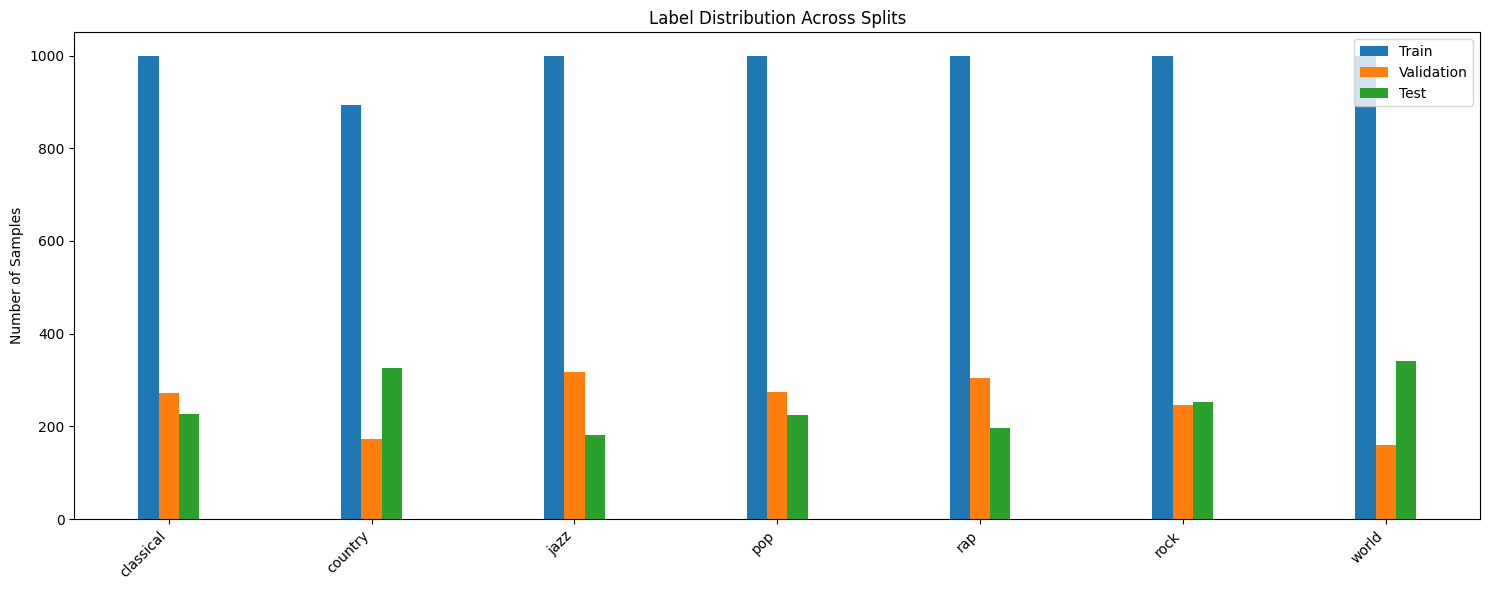

In [84]:
train_counts = y_train.sum(axis=0)
val_counts = y_val.sum(axis=0)
test_counts = y_test.sum(axis=0)

x = np.arange(len(mlb))
width = 0.1

plt.figure(figsize=(15, 6))
plt.bar(x - width, train_counts, width, label='Train')
plt.bar(x, val_counts, width, label='Validation')
plt.bar(x + width, test_counts, width, label='Test')

plt.xticks(x, mlb, rotation=45, ha='right')
plt.ylabel('Number of Samples')
plt.title('Label Distribution Across Splits')
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
from data_processing.data_loader import SpectrogramDataset
import torch
from torch.utils.data import DataLoader
from model.att_cnn import SpectrogramAttentionCNN, train_model, evaluate_model

img_size = (128, 128)
train_dataset = SpectrogramDataset(X_train, y_train, img_size=img_size, augment=True)
test_dataset = SpectrogramDataset(X_test, y_test, img_size=img_size)
val_dataset = SpectrogramDataset(X_val, y_val, img_size=img_size)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_processes, drop_last=True, )
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=n_processes, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_processes, drop_last=True)

Продемонстрируем ниже чудеса аугментации тренировочных данных, это необходимо для избежания переобучения.

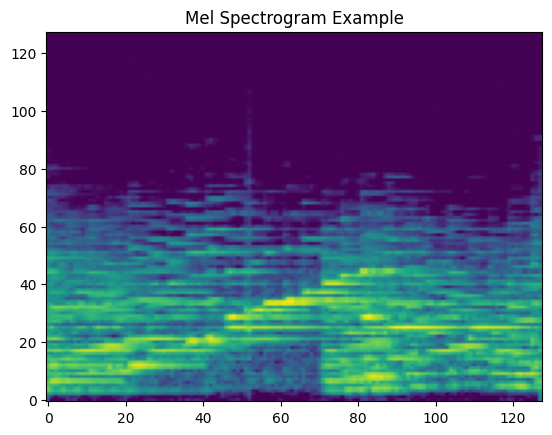

In [85]:
test = train_loader.dataset[1000][0]
import matplotlib.pyplot as plt

plt.imshow(test[0], aspect='auto', origin='lower', cmap='viridis')
plt.title("Mel Spectrogram Example")
plt.show()

Ну и теперь пройдемся по различным конфигурациям, чтобы понять, какую модель стоить оставить дообучать далее. Все-таки когда-то приходится определяться.

In [61]:
import itertools

params_grid = {
    "use_attention": [True, False],
    "loss_fn": ["focal", "bce"],
}
model_dir = "model_cache_2"
results = []
num_classes = len(mlb)

for combo in itertools.product(*params_grid.values()):
    config = dict(zip(params_grid.keys(), combo))
    print(f"Running: {config}")
    metrics = run_experiment(
        num_classes=num_classes,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        y_train=y_train,
        mlb=mlb,
        num_epochs=20,
        use_attention=config["use_attention"],
        loss_fn=config["loss_fn"],
        use_scheduler=True,
        device="mps",
        save_path=f"{model_dir}/attn{config["use_attention"]}_loss{config["loss_fn"]}.pth",
    )
    results.append({**config, **metrics})

In [57]:
import os 

device = "mps"
num_classes = len(mlb)
bootstrap_results = {}
model_dir = "model_cache"

for fname in os.listdir(model_dir):
    if fname.endswith(".pth"):
        model_path = os.path.join(model_dir, fname)
        print(f"Processing: {fname}")
        use_attn = False if fname[4:fname.find("_")] == "False" else True
        model = load_model(model_path, num_classes=num_classes, device=device, use_attention=use_attn)
        f1_scores = bootstrap_f1(model, test_loader, device=device, n_iter=100)
        bootstrap_results[fname] = f1_scores

Processing: attnFalse_lossbce.pth
Processing: attnTrue_lossbce.pth
Processing: attnTrue_lossfocal.pth
Processing: attnFalse_lossfocal.pth


In [58]:
import scipy.stats as sts
import pandas as pd

df = pd.DataFrame(bootstrap_results)

print("Mean F1-scores:")
print(df.mean().sort_values(ascending=False))
print()
model_names = list(df.columns)
for i, name_a in enumerate(model_names):
    for name_b in model_names[i+1:]:
        stat, p = sts.wilcoxon(df[name_a], df[name_b])
        print(f"{name_a} vs {name_b}: p = {p:.4f}")


Mean F1-scores:
attnTrue_lossbce.pth       0.390802
attnTrue_lossfocal.pth     0.343132
attnFalse_lossbce.pth      0.284434
attnFalse_lossfocal.pth    0.281564
dtype: float64

attnFalse_lossbce.pth vs attnTrue_lossbce.pth: p = 0.0000
attnFalse_lossbce.pth vs attnTrue_lossfocal.pth: p = 0.0000
attnFalse_lossbce.pth vs attnFalse_lossfocal.pth: p = 0.0077
attnTrue_lossbce.pth vs attnTrue_lossfocal.pth: p = 0.0000
attnTrue_lossbce.pth vs attnFalse_lossfocal.pth: p = 0.0000
attnTrue_lossfocal.pth vs attnFalse_lossfocal.pth: p = 0.0000


Внимание работает

- Повышение F1 с ~0.28 до ~0.39 при использовании BCE и внимания.
- Это статистически значимо: p-value = 0.0000 во всех сравнениях с attnTrue_lossbce.pth.


BCE лучше, чем Asymmetric Focal Loss

- Даже при использовании внимания BCE выигрывает у Focal (0.391 vs 0.343),
- Все сравнения между BCE и Focal дают p < 0.001, т.е. значимые.

Фокусное внимание не помогает на этом датасете

- Оно ухудшает результат при всех конфигурациях.

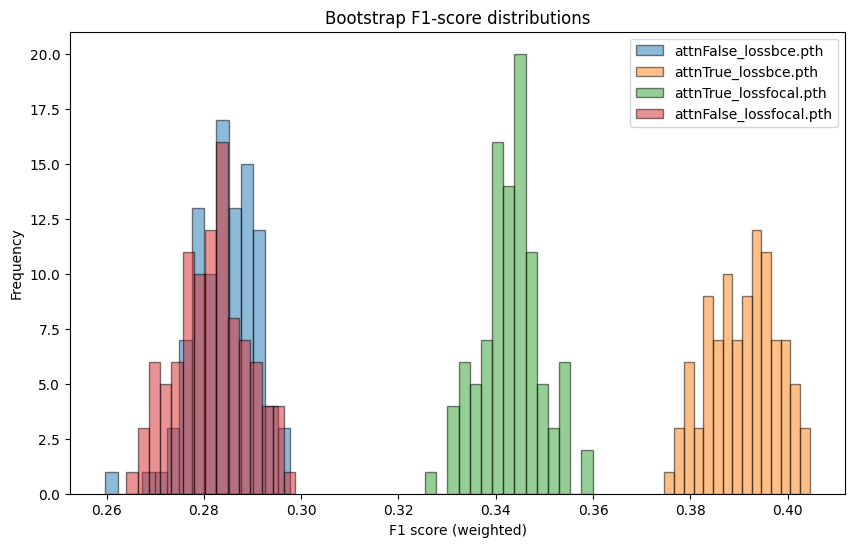

In [59]:
plt.figure(figsize=(10, 6))
for name in df.columns:
    plt.hist(df[name], bins=15, alpha=0.5, label=name, edgecolor='black')
plt.title("Bootstrap F1-score distributions")
plt.xlabel("F1 score (weighted)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Теперь на примере лучшей модели можно подробнее разобрать, что происходит под капотом. Мне, например, было безумно интересно, как выглядит карта внимания на наших спектрограммках.

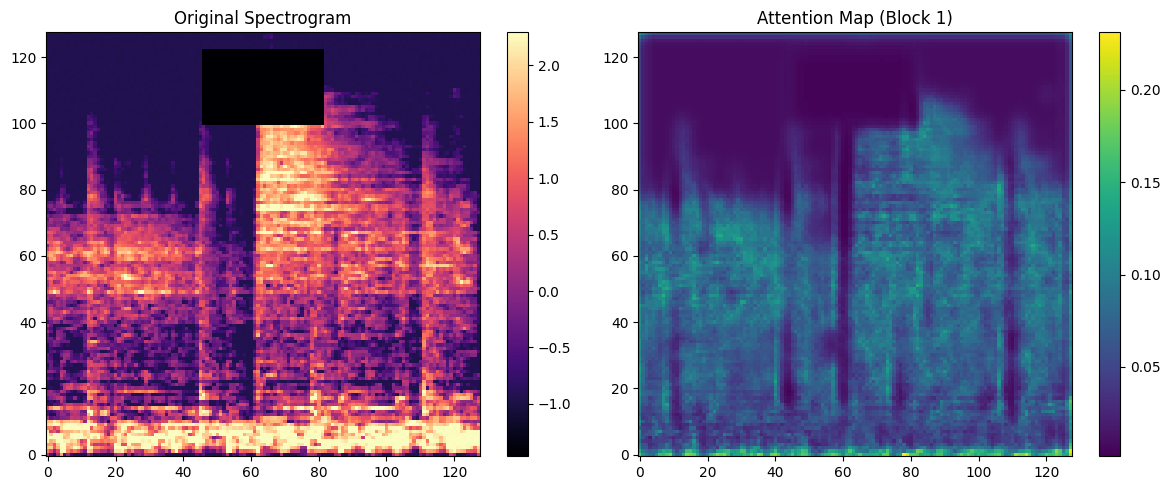

In [60]:
model = SpectrogramAttentionCNN(num_classes=num_classes, use_attention=True)
model.load_state_dict(torch.load("model_cache/attnTrue_lossbce.pth", map_location=torch.device("mps")))
model.to("mps")

sample = next(iter(test_loader))[0][0].unsqueeze(0)
visualize_attention(model, sample, device='mps')

И раз пошла такая пьянка, смотрим внимательнее на отчетик модели на тесте.

In [52]:
_ = evaluate_model(model, test_loader, pd.Series(mlb).to_frame('classes_'), device=device, verbose=1)

Classification Report:
               precision    recall  f1-score   support

   classical       0.51      0.93      0.66      1000
     country       0.37      0.23      0.29       155
        jazz       0.64      0.51      0.57      1000
         pop       0.82      0.08      0.15      1000
         rap       0.75      0.48      0.59       318
        rock       0.39      0.62      0.48      1000
       world       0.33      0.05      0.09       999

   micro avg       0.50      0.44      0.47      5472
   macro avg       0.55      0.42      0.40      5472
weighted avg       0.55      0.44      0.40      5472
 samples avg       0.43      0.44      0.43      5472

Accuracy: 0.4317


Можно теперь сделать оценку, чтобы понять, лоханулись ли мы или нет. 
Если использовалась бы случайная модель, то для 7 классов получили бы 1/7 ≈ 14.3% точности - это самый наивный бейзлайн.
Если использовать majority class baseline: с перекосом в сторону, скажем, classical или pop, точность могла бы быть 18–25%. А мы вон как справились, причем оценка была максимально честная (датасеты разные, музыка сырая, треки не пересекаются вообще).